In [2]:
import torch
from torch import nn
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import os
import csv

# helpers
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes (same as original, no changes here)
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = dots.softmax(dim=-1)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViTPE(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool='cls', channels=1, dim_head=64, dropout=0., emb_dropout=0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_height, p2=patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim=1) if self.pool == 'mean' else x[:, 0]
        x = self.to_latent(x)
        return self.mlp_head(x)

# Hyperparameters
lr = 1e-3
batch_size = 64
num_epochs = 100
patch_size = 7  # Divides 28x28 image evenly
image_size = 28
num_classes = 10
dim = 128
depth = 6
heads = 8
mlp_dim = 512
dropout = 0.1
emb_dropout = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset (Updated for MNIST)
print("==> Preparing MNIST dataset...")
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

# Initialize ViTPE Model
print("==> Building Vision Transformer model for MNIST...")
net = ViTPE(
    image_size=image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    dim=dim,
    depth=depth,
    heads=heads,
    mlp_dim=mlp_dim,
    dropout=dropout,
    emb_dropout=emb_dropout,
    channels=1  # Single-channel for grayscale
).to(device)

==> Preparing MNIST dataset...
==> Building Vision Transformer model for MNIST...


In [3]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# 定义训练函数
def train(epoch):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    start_time = time.time()

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # 前向传播
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        print(f"Train Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx+1}/{len(train_loader)}] "
              f"Loss: {loss.item():.4f} | Acc: {100.*correct/total:.2f}%")

    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1} completed in {epoch_time:.2f}s.")
    return epoch_time, 100. * correct / total

def test(epoch):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    start_time = time.time()

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    inference_time = time.time() - start_time
    acc = 100. * correct / total
    print(f"Test Epoch [{epoch+1}/{num_epochs}] "
          f"Loss: {test_loss/len(test_loader):.4f} | Acc: {acc:.2f}% | Inference Time: {inference_time:.2f}s")
    return acc, inference_time

In [9]:
# 加载检查点状态
checkpoint_path = "./VITPE_lr_1e-3_MNIST_checkpoint.pth"
if os.path.exists(checkpoint_path):
    print(f"Loading checkpoint from {checkpoint_path}...")
    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    scheduler.load_state_dict(checkpoint['scheduler'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resuming from epoch {start_epoch} with best accuracy {best_acc:.2f}%")
else:
    print("No checkpoint found. Starting from scratch.")
    start_epoch = 0
    best_acc = 0

# 创建或打开 CSV 文件
csv_file = "training_results_VITPE_lr_1e-3_MNIST.csv"
write_header = not os.path.exists(csv_file)

with open(csv_file, "a", newline="") as f:
    writer = csv.writer(f)
    if write_header:
        writer.writerow(["Epoch", "Train Time (s)", "Inference Time (s)", "Accuracy (%)"])

    # 开始训练
    train_times = []
    inference_times = []
    accuracies = []

    for epoch in range(start_epoch, num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        train_time, train_acc = train(epoch)
        train_times.append(train_time)

        acc, inference_time = test(epoch)
        accuracies.append(acc)
        inference_times.append(inference_time)

        scheduler.step()

        if acc > best_acc:
            print("Saving best model...")
            state = {
                'model': net.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'acc': acc,
                'epoch': epoch,
            }
            torch.save(state, checkpoint_path)
            best_acc = acc

        writer.writerow([epoch+1, train_time, inference_time, acc])
        f.flush()
        print(f"Epoch {epoch+1} results saved to CSV.")

# 输出最终记录
print("\n=== Final Results ===")
print(f"Average Training Time per Epoch: {sum(train_times) / len(train_times):.2f}s")
print(f"Average Inference Time: {sum(inference_times) / len(inference_times):.2f}s")
print(f"Best Accuracy: {best_acc:.2f}%")

Loading checkpoint from ./VITPE_lr_1e-3_MNIST_checkpoint.pth...


C:\Users\ZBLibra\AppData\Local\Temp\ipykernel_25392\3609421237.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Resuming from epoch 98 with best accuracy 99.17%
Epoch 99/100
Train Epoch [99/100] Batch [1/938] Loss: 0.0002 | Acc: 100.00%
Train Epoch [99/100] Batch [2/938] Loss: 0.0000 | Acc: 100.00%
Train Epoch [99/100] Batch [3/938] Loss: 0.0000 | Acc: 100.00%
Train Epoch [99/100] Batch [4/938] Loss: 0.0000 | Acc: 100.00%
Train Epoch [99/100] Batch [5/938] Loss: 0.0001 | Acc: 100.00%
Train Epoch [99/100] Batch [6/938] Loss: 0.0000 | Acc: 100.00%
Train Epoch [99/100] Batch [7/938] Loss: 0.0000 | Acc: 100.00%
Train Epoch [99/100] Batch [8/938] Loss: 0.0000 | Acc: 100.00%
Train Epoch [99/100] Batch [9/938] Loss: 0.0000 | Acc: 100.00%
Train Epoch [99/100] Batch [10/938] Loss: 0.0001 | Acc: 100.00%
Train Epoch [99/100] Batch [11/938] Loss: 0.0001 | Acc: 100.00%
Train Epoch [99/100] Batch [12/938] Loss: 0.0001 | Acc: 100.00%
Train Epoch [99/100] Batch [13/938] Loss: 0.0000 | Acc: 100.00%
Train Epoch [99/100] Batch [14/938] Loss: 0.0000 | Acc: 100.00%
Train Epoch [99/100] Batch [15/938] Loss: 0.0000 | 

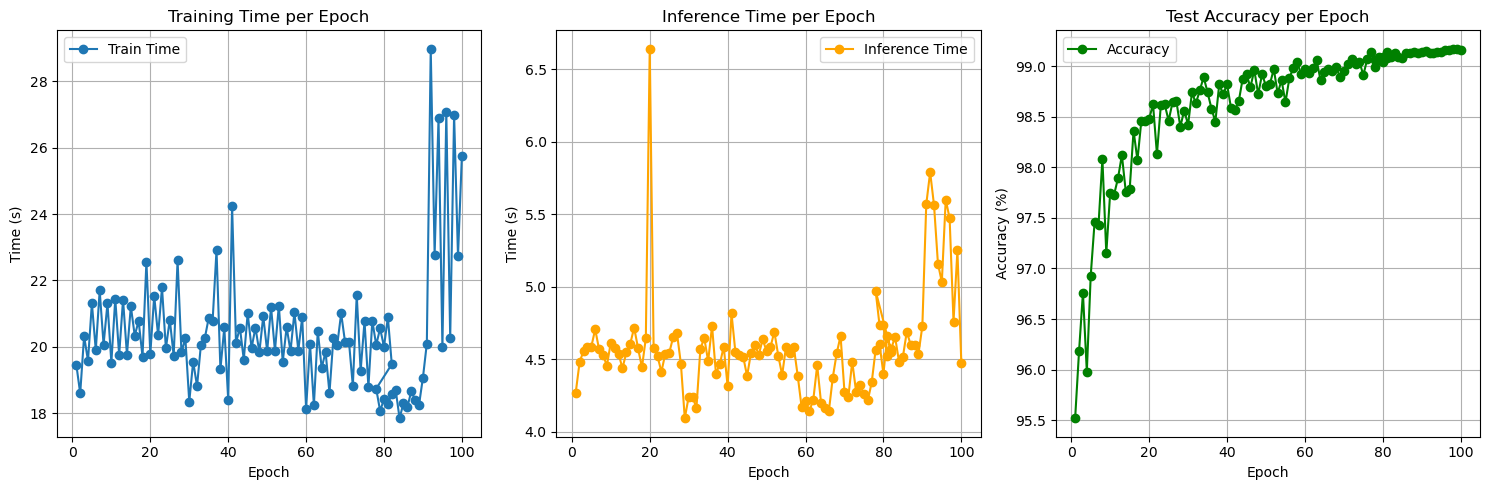

'VITPE_lr_1e-3_training_visualization.png'

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'training_results_VITPE_lr_1e-3_MNIST.csv'
data = pd.read_csv(file_path)

# Extract data for plotting
epochs = data['Epoch']
train_times = data['Train Time (s)']
inference_times = data['Inference Time (s)']
accuracies = data['Accuracy (%)']

# Plot the data
plt.figure(figsize=(15, 5))

# Training time per epoch
plt.subplot(1, 3, 1)
plt.plot(epochs, train_times, marker='o', label='Train Time')
plt.xlabel("Epoch")
plt.ylabel("Time (s)")
plt.title("Training Time per Epoch")
plt.grid(True)
plt.legend()

# Inference time per epoch
plt.subplot(1, 3, 2)
plt.plot(epochs, inference_times, marker='o', color='orange', label='Inference Time')
plt.xlabel("Epoch")
plt.ylabel("Time (s)")
plt.title("Inference Time per Epoch")
plt.grid(True)
plt.legend()

# Test accuracy per epoch
plt.subplot(1, 3, 3)
plt.plot(epochs, accuracies, marker='o', color='green', label='Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy per Epoch")
plt.grid(True)
plt.legend()

# Finalize and save the figure
plt.tight_layout()
output_path = "VITPE_lr_1e-3_training_visualization.png"
plt.savefig(output_path)
plt.show()

output_path
